<a href="https://colab.research.google.com/github/Vaycold/statistics_seminar/blob/main/covid19_tweet/LR_Word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [477]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer    
from google.colab import files

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split


warnings.filterwarnings('ignore')

os.environ['KAGGLE_USERNAME'] = 'kimgodbang'
os.environ['KAGGLE_KEY'] = '1c0e1716b23829d4381dcbced37ba49b'

!rm *.*
!kaggle competitions download -c sentiment-analysis-of-covid-19-related-tweets

train_df = pd.read_csv('training.csv')
test_df = pd.read_csv('validation.csv')

for module in ['stopwords', 'punkt', 'wordnet'] :
    nltk.download(module)

  0% 0.00/518k [00:00<?, ?B/s]
100% 518k/518k [00:00<00:00, 72.1MB/s]
  0% 0.00/254k [00:00<?, ?B/s]
100% 254k/254k [00:00<00:00, 60.8MB/s]
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [478]:
def labelsplit(labels) :
    
    label = labels.replace(' ',',').split(',')
    for idx, lab in enumerate(label) :
        label[idx] = int(lab)
    return label

In [480]:
train_df['label']  = train_df['Labels'].apply(lambda x :  labelsplit(x))

,ID,Tweet,Labels,label
0,1,NO JOKE I WILL HOP ON A PLANE RN! (Well after ...,0 10,"[0, 10]"
1,2,BanMediaHouse whose is responsible for spreadi...,6,[6]


In [481]:
onehot = np.zeros((5000,11))
for i in range(5000) : # 0~5000 row
    for j in train_df.label[i] : # j = value   
        onehot[i,j]  = 1
cols_target = ['0','1','2','3','4','5','6','7','8','9','10']
onehot = pd.DataFrame(onehot, columns=cols_target)

,0,1,2,3,4,5,6,7,8,9,10
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [482]:
train_df = pd.concat(
    [train_df, onehot], axis=1
).drop(['ID','Labels', 'label'],axis=1)

,Tweet,0,1,2,3,4,5,6,7,8,9,10
0,NO JOKE I WILL HOP ON A PLANE RN! (Well after ...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,BanMediaHouse whose is responsible for spreadi...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## EDA

In [483]:
# 단어의 갯수

word_count = train_df['Tweet'].apply(lambda x : len(x.split(' ')))
word_count

0       13
1       15
2       19
3       16
4       19
        ..
4995    14
4996    23
4997     9
4998    23
4999    13
Name: Tweet, Length: 5000, dtype: int64

In [484]:
print(f' Tweet 중 단어가 가장 많은 tweet의 단어 수 : {np.max(word_count)}')
print(f' Tweet 중 단어가 가장 적은 tweet의 단어 수 : {np.min(word_count)}')
print(f' 평균 tweet 의 길이 : {np.mean(word_count)}')
print(f' tweet 의 길이의 중간값 : {np.median(word_count)}')

 Tweet 중 단어가 가장 많은 tweet의 단어 수 : 30
 Tweet 중 단어가 가장 적은 tweet의 단어 수 : 1
 평균 tweet 의 길이 : 16.9214
 tweet 의 길이의 중간값 : 17.0


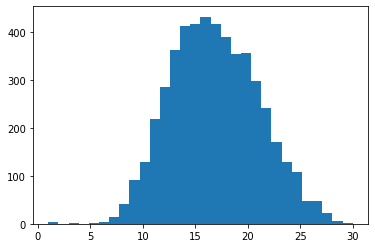

In [485]:
plt.hist(word_count, bins=30)
plt.show()

## 텍스트 클렌징

In [486]:
stop = stopwords.words('english')
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text
def  clean_text(df, text_field='Tweet', new_text_field_name='clean_tweet'):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x : x.lower())
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x : x.replace('corona','covid'))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x : x.replace('coronavirus','virus'))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: word_tokenize(x))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: word_lemmatizer(x))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: ' '.join(x))
    return df

In [487]:
def clean_df(df) :
    DF = clean_text(df, 'Tweet', 'clean_tweet')
    try :
        DF = DF[['clean_tweet','0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']]
        DF.columns = ['Tweet','0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    except :
        DF = DF[['ID','clean_tweet']]
        DF.columns = ['ID','Tweet']
    
    return DF

In [488]:
train_df = clean_df(train_df)
test_df = clean_df(test_df)

In [489]:
train_df.head(2)

,Tweet,0,1,2,3,4,5,6,7,8,9,10
0,joke hop plane rn well covid lol,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,banmediahouse whose responsible spreading fake...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [490]:
test_df.head(2)

,ID,Tweet
0,5001,forgot math test failing teacher opening back ...
1,5002,covid effected came delhi bihar lakhisarai dis...


 Tweet 중 단어가 가장 많은 tweet의 단어 수 : 21
 Tweet 중 단어가 가장 적은 tweet의 단어 수 : 1
 평균 tweet 의 길이 : 10.1706
 tweet 의 길이의 중간값 : 10.0


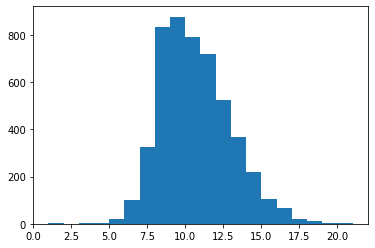

In [491]:
word_count = train_df['Tweet'].apply(lambda x : len(x.split(' ')))
print(f' Tweet 중 단어가 가장 많은 tweet의 단어 수 : {np.max(word_count)}')
print(f' Tweet 중 단어가 가장 적은 tweet의 단어 수 : {np.min(word_count)}')
print(f' 평균 tweet 의 길이 : {np.mean(word_count)}')
print(f' tweet 의 길이의 중간값 : {np.median(word_count)}')
plt.hist(word_count, bins=20)
plt.show()

In [492]:
np.quantile(word_count, 0.025)

6.0

## 토큰화 및 패딩

In [493]:
train_tweet = train_df['Tweet'].values
test_tweet = test_df['Tweet'].values

In [494]:
train_tweet[:2]

array(['joke hop plane rn well covid lol',
       'banmediahouse whose responsible spreading fake communal story pandemic covid situation'],
      dtype=object)

In [495]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_tweet)

train_token = tokenizer.texts_to_sequences(train_tweet)
train_token[0]

[8, 1838, 2382, 357, 96, 1, 133]

In [496]:
print(train_tweet[0])
print(train_token[0])

joke hop plane rn well covid lol
[8, 1838, 2382, 357, 96, 1, 133]


In [497]:
word_vocab = tokenizer.word_index
print(word_vocab)

{'covid': 1, 'covidvirus': 2, 'virus': 3, 'april': 4, 'fool': 5, 'u': 6, 'im': 7, 'joke': 8, 'people': 9, 'get': 10, 'like': 11, 'case': 12, 'day': 13, 'shit': 14, 'na': 15, 'go': 16, 'death': 17, 'new': 18, 'got': 19, 'say': 20, 'one': 21, 'dont': 22, 'time': 23, 'gon': 24, 'today': 25, 'yall': 26, 'really': 27, 'tomorrow': 28, 'please': 29, 'need': 30, 'going': 31, 'know': 32, 'cant': 33, 'thing': 34, 'world': 35, 'think': 36, 'stay': 37, 'make': 38, 'see': 39, 'government': 40, 'trump': 41, 'home': 42, 'positive': 43, 'let': 44, 'fuck': 45, 'would': 46, 'month': 47, 'tell': 48, 'back': 49, 'year': 50, 'good': 51, 'pandemic': 52, 'life': 53, 'away': 54, 'still': 55, 'said': 56, 'come': 57, 'right': 58, 'stop': 59, 'want': 60, 'getting': 61, 'even': 62, 'china': 63, 'prank': 64, 'news': 65, 'whole': 66, 'guy': 67, 'test': 68, 'take': 69, 'india': 70, 'due': 71, 'hope': 72, 'first': 73, 'someone': 74, 'god': 75, 'total': 76, 'way': 77, 'week': 78, 'end': 79, 'already': 80, 'tested': 81

In [498]:
print(f'단어 전체의 갯수 {len(word_vocab)}')

단어 전체의 갯수 8517


In [499]:
maxlen = 21 # 전처리 후 최댓값
train_pad = pad_sequences(train_token, maxlen = maxlen, padding = 'pre')
print(train_tweet[0])
print(train_token[0])
print(train_pad[0])

joke hop plane rn well covid lol
[8, 1838, 2382, 357, 96, 1, 133]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    8 1838 2382  357   96    1  133]


In [500]:
print(type(train_pad))
print(train_pad.shape)
print(train_pad[0].shape)

<class 'numpy.ndarray'>
(5000, 21)
(21,)


# 벡터화
  - TF-IDF
  - WORD2VEC

### TF-IDF

In [502]:

Tfvec = TfidfVectorizer(ngram_range = (1,3), max_features = 500, stop_words='english')

x = Tfvec.fit_transform(train_tweet)
x.shape

(5000, 500)

In [503]:
y = np.array(train_label)
y.shape

(5000,)

In [504]:
x.shape

(5000, 500)

In [505]:
y.shape

(5000,)

In [506]:
# test 데이터
x_test = Tfvec.transform(test_tweet)
x_test.shape

(2500, 500)

### WORD2VEC

## 데이터셋 나누기

In [508]:
def one(x) :
    if x > 2 :
        return 1
    else :
        return 0

In [195]:
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size = 0.3)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(4000, 500) (4000,)
(1000, 500) (1000,)


# MODEL 
  - LR

In [196]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight  = 
                        {0 : 0.58,
                         1 : 0.42})
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 0.58, 1: 0.42}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [522]:

x = Tfvec.fit_transform(train_tweet) # 벡터화된 training value
x_test = Tfvec.transform(test_tweet) # 벡터화된 test value
sfk = StratifiedKFold(n_splits = 5, shuffle=True) # Stratifie Kfold 


# Logit Reg

def auto(*filename) :
    answer = pd.DataFrame()
    answer_p = pd.DataFrame()
    submission = test_df.drop(['Tweet'], axis=1)
    submission['Labels'] = 0


    for label in cols_target :
        y = np.array(train_df[label].values)
        y0 = len(train_df[train_df[label]==0]) / len(train_df)
        y1 = len(train_df[train_df[label]==1]) / len(train_df)
        weight_list = {0 : y1, 
                       1 : y0}
    
        y_onehot = to_categorical(y)
        p = pd.DataFrame()
        p2 = pd.DataFrame()
        idx = 0

        for train_index, val_index in sfk.split(x,y) :

            x_train, x_val = x[train_index], x[val_index]
            y_train, y_val = y[train_index], y[val_index]

            lr = LogisticRegression(C=40,
                                    class_weight = weight_list) # 분류기 : 로지스틱 회귀
            lr.fit(x_train, y_train)
            pred = lr.predict(x_test)
            prob = lr.predict_proba(x_test)[:,1]
            
            p[idx] = pred
            p2[idx] = prob
            idx += 1
    
            answer[label] = [one(sum(p.loc[i].tolist())) for i in range(pred.shape[0])]
            answer_p[label] = [np.sum(p2.loc[i].tolist()) for i in range(pred.shape[0])]


    Answer = np.array(answer)
    Answer_p = np.array(answer_p)
    submis = onehot[:pred.shape[0]]

    for row in range(pred.shape[0]) :
        if Answer_p[row].max() <= 0.5 :
            for idx, value in enumerate(Answer[row]) :
                if value == Answer[row].max() :
                    submis[row][idx] = 1
    
    for i in range(pred.shape[0]) :
        one_row = []
        for cat in cols_target :
            if int(submis[i:i+1][cat].values) == 1 :
                one_row.append(str(cat))
        submission['Labels'][i] = ' '.join(one_row)

    name = 'model_'  + str(filename)+ '.csv'
    submission.to_csv(name, index=False)
    files.download(name)

In [524]:
auto('로지스틱회귀:C=40')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>